## Reinforcement Learning on Cliff Walking Problem

In this notebook a simple reinforcement learning algorithm will be implemented from scratch. I will model the environment with a 2D array. For further knowledge please look at the following book:

Reinforcement Learning: An Introduction
R. Sutton, and A. Barto.
The MIT Press, Second edition, (2018)




Let us start by importing the related libraries

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt


In the following sections I will use a "copy" command to copy the action list and also for debugging purposes I want to see all the elements of a numpy regardless of the size of the matrix. To enable these the followings should be written:

In [2]:
import copy
np.set_printoptions(threshold = np.inf)

![Cliff Walking](https://cdn-images-1.medium.com/max/1600/1*cAezGWdRG9_3DXrKg3uftw.jpeg)

The task is simply to reach the point G by starting from point S in the map. However, there is a cliff we should avoid so that -100 reward incurs if a transition into the cliff is made. We will use two approaches to solve the problem as it can be seen from the picture. If we use **SARSA (State-Action-Reward-State-Action)** the agent will choose the safer path above. On the other side if we use **Q-Learning** the agent will choose relatively more dangerous but closer path. Note that these two methods are versions of **Temporal Difference** methods since they update the value function at each _time step_, not at each _episode_. Let's start with global methods.

In [26]:
def display2D(array):
    for row in array:
        # Loop over columns.
        for column in row:
            print(column.getSign(), end=" ")
        # getSign() basically returns 'O' to represent nonvisited element
        # 'C' to cliff and 'X' to represent visited element
        print(end="\n")

To display the rewards for debugging purpose

In [27]:
def displayRewards(array):
    for row in array:
        # Loop over columns
        for column in row:
            print(column.getReward(), end=" ")
        print(end='\n')

To handle the rewards the following method is written. Note that rewards are strictly taken from the book. Different rewards will result in different solutions so that **reward function implementation is one of the most important concepts in RL**. For this application the cliffs incurs -100 and other transitions incur -1. Also note that, generally rewards are implemented via a state-action matrix. However, for this problem actually what matters only is the state where you end up, not the action. Hence, I will embed the rewards into the states. This method will not work when the action also matters.

In [28]:
def handleRewards(array,last_row, column):
    # column - 2 equals to number of cliff elements
    for i in range (column - 2):
        array[last_row][i+1].setReward(-100)
    #array[last_row][column - 1].setReward(50)

In [29]:
def shiftAndAddArray(arrayToShift, newElement):
    for i in range(len(arrayToShift) - 1):
        arrayToShift[i] = arrayToShift[i + 1]
    arrayToShift[len(arrayToShift) - 1] = newElement
    return arrayToShift

In [30]:
actionList = [0, 1, 2, 3]       # 0 for right,1 for down, 2 for up, 3 for left

In [31]:
class States:
    #sign indicates the position if sign is C it is cliff, if S starting point F is finishing point
    # O is empty spot X is where the agent travels
    def __init__(self,sign,reward,row,column):
        self.sign = sign
        self.reward = reward
        self.row = row
        self.column = column

    # returns the reward of a particular state(note that states are enough for this problem for rewards)
    def getReward(self):
        return self.reward

    # returns the signs of a particular state
    def getSign(self):
        return self.sign

    # changes the sign of a particular state
    def changeSign(self,newSign):
        self.sign = newSign

    # changes the reward of a particular state
    def setReward(self,newReward):
        self.reward = newReward

    """Returns an action (encoded integer) by using a epsilon-greedy approach"""
    def eGreedy(self,Qvalue,epsilon,last_row_index, last_column_index): # returns action
        newActionList = actionList.copy()  # new action list to choose by eliminating prohibited actions
        if self.row == 0 and self.column == 0: # no up or left
            newActionList.remove(3)   # remove left
            newActionList.remove(2)   # remove up
        elif self.row == last_row_index and self.column == 0:  # no down or left
            newActionList.remove(3)   # remove left
            newActionList.remove(1)   # remove down
        elif self.row == 0 and self.column == last_column_index:  # no up or right
            newActionList.remove(0)   # remove right
            newActionList.remove(2)   # remove up
        elif self.row == last_row_index and self.column == last_column_index:  # no down or right
            newActionList.remove(0)   # remove right
            newActionList.remove(1)   # remove down
        # More general cases for prohibiting actions
        elif self.row == 0:  # no up
            newActionList.remove(2) # remove up
        elif self.row == last_row_index: # no down
            newActionList.remove(1) # remove down
        elif self.column == 0:  # no left
            newActionList.remove(3) # remove left
        elif self.column == last_column_index:  # no right
            newActionList.remove(0) # remove right

        probability = random.uniform(0, 1) # random number between 0 and 1 for epsilon greedy
        # To ensure exploration and exploitation e-greedy approach is used
        if probability < 1 - epsilon:  # greedy action
            return self.findMaxIndex(Qvalue, newActionList,last_row_index,last_column_index)
        else:  # random action
            return random.choice(newActionList)

    """Returns a pure greedy action without exploration"""
    def ePureGreedy(self,Qvalue,last_row_index, last_column_index):
        newActionList = actionList.copy()  # copy action list again
        if self.row == 0 and self.column == 0:  # no up or left
            newActionList.remove(3)  # remove left
            newActionList.remove(2)  # remove up
        elif self.row == last_row_index and self.column == 0:  # no down or left
            newActionList.remove(3)  # remove left
            newActionList.remove(1)  # remove down
        elif self.row == 0 and self.column == last_column_index:  # no up or right
            newActionList.remove(0)  # remove right
            newActionList.remove(2)  # remove up
        elif self.row == last_row_index and self.column == last_column_index:  # no down or right
            newActionList.remove(0)
            newActionList.remove(1)
        # More general cases
        elif self.row == 0:  # no up
            newActionList.remove(2)  # remove up
        elif self.row == last_row_index:  # no down
            newActionList.remove(1)  # remove down
        elif self.column == 0:  # no left
            newActionList.remove(3)  # remove left
        elif self.column == last_column_index:  # no right
            newActionList.remove(0)  # remove right

        return self.findMaxIndex(Qvalue, newActionList,last_row_index,last_column_index)

    # change the state according to the action
    def takeAction(self,array,action,Qvalue,last_row_index, last_column_index,epsilon):
        #  note that action is an integer value
        #  if 0 right, 1 down, 2 up, 3 left
        # the following 4 lines of code can be discarded by inputting newAction list to this method
        # I used a recursive approach for the solution by checking again whether motions are valid

        # row = 0 -> we can't go up - call eGreedy for a valid action
        if self.row == 0 and action == 2:  # if row 0 then up is not valid - call again eGreedy
            newAction = self.eGreedy(Qvalue, epsilon,last_row_index, last_column_index)
            return self.takeAction(array,newAction,Qvalue,last_row_index,last_column_index,epsilon)
        # row == last_row_index -> can't go down
        elif self.row == last_row_index and action == 1:
            newAction = self.eGreedy(Qvalue, epsilon,last_row_index, last_column_index)
            return self.takeAction(array, newAction,Qvalue,last_row_index,last_column_index,epsilon)
        # column == last_column_index can't go right
        elif self.column == last_column_index and action == 0:
            newAction = self.eGreedy(Qvalue, epsilon,last_row_index, last_column_index)
            return self.takeAction(array, newAction,Qvalue,last_row_index,last_column_index,epsilon)
        # column = 0 -> can't go left
        elif self.column == 0 and action == 3:
            newAction = self.eGreedy(Qvalue, epsilon,last_row_index, last_column_index)
            return self.takeAction(array, newAction,Qvalue, last_row_index, last_column_index,epsilon)

        else:  # if everything is valid
            if action == 0:  # right
                next_state = array[self.row][self.column+1]  # update the state
            elif action == 1:  # down
                next_state = array[self.row + 1][self.column]  # update the state
            elif action == 2:  # up
                next_state = array[self.row - 1][self.column]  # update the state
            elif action == 3:  # left
                next_state = array[self.row][self.column - 1]
        return next_state

    def findMaxIndex(self, Qvalue, actionList, last_row_index, last_column_index):  # returns index of maximum number, for maximum value action
        """2D array modeled as a vector such a way that from left-to-right and up-to-down state number is incremented
        i.e  0 - 1 - 2 - ..... - 11
             12 - 13 - ....... - 23
             24 - 25 - ....... - 35
             36 - 37 - ....... - 47

        Also state-action matrix is constrcuted and values Q values are stored in that in the following way
        i.e      Actions
        States   Right     Down    Up     Left
        ...       ...       ...     ...     ....
        State 11  -4.4      14.6    0.6    6.4
        ...       ...       ...     ...     ....
        if the model is 12 row and 4 columns then state 11 refers to the right-top point in which case the maximum
        action will be going down
        """
        maxIndex = np.argmax(Qvalue[self.row*12+self.column])
        return maxIndex

    #  checks whether the current state is terminal or not for ending the episode
    def isTerminal(self,last_row_index):
        # returns 1 if the current state is terminal - cliff or finish point
        if self.row == last_row_index and self.column > 0:
            return 1
        else:
            return 0

![Q](https://cdn-images-1.medium.com/max/1600/1*d203n7cIso731qhJ7eOAkg.png)

In [ ]:

"""
@params
    array = state grid we constructed
    row_number = #rows of state grid
    column_number = #columns of state grid
    episodes = #episodes
    steps = #steps within episodes
    alpha = learning rate
    gama = discount factor

"""

def applyQlearning(array,row_number,column_number,episodes,steps,alpha,gama):
    '''Step 1: Initialize epsilon to 0.1, compute state_number, and set last_row_index, last_column_index, and action_number to 4.
    Step 2: Create a Q-table of size (state_number × action_number) with random values.

    Step 3: Set all Q-values of the terminal state (last cell) to 0 to indicate no further reward.
    Step 4: Initialize rewardArray, episodeArray, and a zero array averageRewardArray of size 40 for smoothing rewards.

    Step 5: Loop for each episode from 0 to episodes, initialize step, count, and totalReward to 0.
    Step 6: Set the starting state as array[3][0] and append the episode index to episodeArray.

    Step 7: While count is within steps and current state is not terminal, increment step and count.
    Step 8: Select an action using ε-greedy policy from current state and Q-table.

    Step 9: Perform the selected action to transition to next_state, and get the immediate reward.
    Step 10: Accumulate the reward to totalReward.

    Step 11: Select the best next action using pure greedy strategy from the next_state.
    Step 12: Get the maximum Q-value for that action and update the Q-value of the current state-action pair.

    Step 13: Transition to the next state for the next iteration.
    Step 14: After the episode ends, update averageRewardArray with the total reward.

    Step 15: Compute the average reward over the non-zero entries in averageRewardArray.
    Step 16: Append this average reward to rewardArray for plotting or analysis.'''

    """
    Implements Q-learning algorithm for the cliff walking problem
    
    @params
        array = state grid we constructed
        row_number = #rows of state grid
        column_number = #columns of state grid
        episodes = #episodes
        steps = #steps within episodes
        alpha = learning rate
        gama = discount factor
    """
    # Step 1: Initialize parameters
    epsilon_q = 0.1
    state_number = row_number * column_number
    last_row_index = row_number - 1
    last_column_index = column_number - 1
    action_number = 4  # Right, Down, Up, Left
    
    # Step 2: Create Q-table with random initial values
    q_table = np.random.rand(state_number, action_number)
    
    # Step 3: Set Q-values for terminal states to 0
    q_table[(last_row_index * column_number + 1):(last_row_index * column_number + last_column_index), :] = 0  # Cliff states
    q_table[last_row_index * column_number + last_column_index, :] = 0  # Goal state
    
    # Step 4: Initialize arrays for tracking rewards and episodes
    rewardArray = []
    episodeArray = []
    windowing_average_samples = 40
    averageRewardArray = np.zeros(windowing_average_samples)
    
    # Step 5: Loop for each episode
    for episode in range(episodes):
        step = 0
        count = 0
        totalReward = 0
        
        # Step 6: Set starting state
        current_state = array[last_row_index][0]
        episodeArray.append(episode)
        
        # Step 7-13: Run episode until terminal state or max steps
        while count < steps and current_state.isTerminal(last_row_index) == 0:
            step += 1
            count += 1
            
            # Step 8: Select action using epsilon-greedy policy
            action = current_state.eGreedy(q_table, epsilon_q, last_row_index, last_column_index)
            
            # Step 9: Take action and observe next state and reward
            next_state = current_state.takeAction(array, action, q_table, last_row_index, last_column_index, epsilon_q)
            reward = next_state.getReward()
            
            # Step 10: Accumulate reward
            totalReward += reward
            
            # Step 11: Find best next action using greedy policy
            best_next_action = next_state.ePureGreedy(q_table, last_row_index, last_column_index)
            
            # Calculate state indices for Q-table
            current_state_idx = current_state.row * column_number + current_state.column
            next_state_idx = next_state.row * column_number + next_state.column
            
            # Step 12: Update Q-value using Q-learning update rule
            q_table[current_state_idx][action] += alpha * (reward + gama * q_table[next_state_idx][best_next_action] - 
                                                         q_table[current_state_idx][action])
            
            # Step 13: Move to next state
            current_state = next_state
        
        # Step 14: Update reward tracking with moving average
        averageRewardArray = shiftAndAddArray(averageRewardArray, totalReward)
        
        # Step 15-16: Calculate average reward and track it
        avg = 0
        count = 0
        for i in range(windowing_average_samples):
            if averageRewardArray[i] != 0:
                avg += averageRewardArray[i]
                count += 1
        
        if count > 0:
            rewardArray.append(avg / count)
        else:
            rewardArray.append(0)
    
    # Display results
    print("Q TRAINING IS OVER")
    episodeArray = episodeArray[10:]
    rewardArray = rewardArray[10:]
    drawPath(array, q_table, last_row_index, last_column_index, epsilon_q)
    plt.plot(episodeArray, rewardArray)
    plt.legend(['Q learning'])
    print(averageRewardArray)
    plt.title(f'Smoothed by averaging {windowing_average_samples} successive episodes')
    # limiting the overall boundary to have a nice vision
    plt.ylim((-120, 0))
    plt.show()
    
    return q_table  # Return the learned Q-table

   


In [33]:
 #  this is for the test after the training
def drawPath(array,Qvalue,last_row_index, last_column_index,epsilon):
    current_state = array[last_row_index][0]  # initial state
    greedyAction = current_state.ePureGreedy(Qvalue,last_row_index,last_column_index)  # action is determined
    while(current_state.isTerminal(last_row_index) == 0):
        next_state = current_state.takeAction(array,greedyAction,Qvalue,last_row_index, last_column_index,epsilon)
        next_state.changeSign("X")
        followingAction = next_state.ePureGreedy(Qvalue,last_row_index, last_column_index)
        current_state = next_state
        greedyAction = followingAction
    display2D(array)

O O O O O O O O O O O O 
O O O O O O O O O O O O 
O O O O O O O O O O O O 
O O O O O O O O O O O O 
OK HERE WE STOP
O O O O O O O O O O O O 
O O O O O O O O O O O O 
O O O O O O O O O O O O 
S C C C C C C C C C C F 
-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 
-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 
-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 
-1 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -1 
CONSTRUCTED
Q TRAINING IS OVER
O O O O O O O O O O O O 
O O O O O O O O O O O O 
X X X X X X X X X X X X 
S C C C C C C C C C C X 
[ -13. -106.  -13.  -15. -107.  -13.  -15.  -15. -108.  -13.  -13. -100.
  -13.  -13.  -13.  -17.  -21.  -17.  -17.  -15.  -13. -111. -111.  -13.
  -15.  -17. -109.  -13.  -13.  -25.  -13. -106.  -13.  -13.  -13. -108.
 -111.  -13.  -13.  -15.]


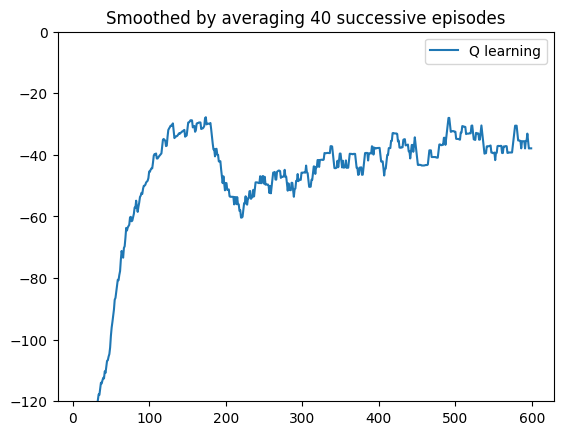

In [34]:
def main():
    episode_number = 600
    steps = 500
    gama = 0.9
    alpha = 0.25
    row_number = 4
    column_number = 12
    #construct the environment here q values are random integers
    stateGrid = [[States('O',-1,y,x) for x in range (column_number)] for y in range(row_number)]
    #print(random.choice(actionList)) this code segment changes a random action from the list
    display2D(stateGrid)
    print("OK HERE WE STOP")
    stateGrid[row_number - 1][0].changeSign('S')
    stateGrid[row_number - 1][column_number - 1].changeSign('F')
    for i in range(10):
        stateGrid[row_number - 1][i+1].changeSign('C')
    #this loop displays the two d array in a neat format
    display2D(stateGrid)
    #construction stopped here
    handleRewards(stateGrid, row_number - 1, column_number)
    displayRewards(stateGrid)
    print("CONSTRUCTED")
    stateGrid2 = copy.deepcopy(stateGrid)
    #applySarsa(stateGrid, row_number, column_number, episode_number, steps, alpha, gama)
    applyQlearning(stateGrid2, row_number, column_number, episode_number, steps, alpha, gama)

if __name__ == "__main__":
    main()
